In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib 

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
def normalise(array):
    # ((X - X_min)/(X_max - X_min) * 2) - 1
    min_value = array.min()
    max_value = array.max()
    
    normalised_array = ((array - min_value)/(max_value - min_value) * 2) - 1
    
    return normalised_array

def make_two_dimensional_ndarray(x, y):
    return np.array([x, y]).transpose()

def normalise_all_columns(ndarray):
    cols = ndarray.shape[1]
    columns = []
    for i in range(cols):
        unnormalised = np.array([element[i] for element in ndarray])
        normalised = normalise(unnormalised)
        columns.append(normalised)
    return np.array(columns).transpose()


In [3]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    padding_ratio = 0.1
    
    x_pad = x_range * padding_ratio
    y_pad = y_range * padding_ratio
    
    x_h = x_range / 1000
    y_h = y_range / 1000
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(
        np.arange(x_min - x_pad, x_max + x_pad, x_h),
        np.arange(y_min - y_pad, y_max + y_pad, y_h)
    )
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.figure(figsize=(20,20))
#     plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.contour(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [80]:
# Import house price data
melbourne_dtypes = {
    'names': ('price', 'lat', 'lon'),
    'formats': ('float32', 'float32', 'float32')
}
melbourne_txns = np.genfromtxt('data/Melbourne_housing_noblanks.csv',
                             delimiter=',', usecols=(4,17,18), skip_header=1, 
                             dtype=melbourne_dtypes, max_rows=500)

y_prices = np.array([txn[0] for txn in melbourne_txns])

lat_unnormalised = np.array([txn[1] for txn in melbourne_txns])
lon_unnormalised = np.array([txn[2] for txn in melbourne_txns])

X = normalise_all_columns(
    make_two_dimensional_ndarray(
        lat_unnormalised,
        lon_unnormalised
    )
)

# X = np.array([[txn[1], txn[2]] for txn in melbourne_txns])

print(y_prices.size)
print(X[1], y_prices[1])

500
(array([-0.15239745,  0.21860468], dtype=float32), 1035000.0)


In [86]:
import tensorflow as tf
import numpy as np

num_of_results = y_prices.size
input_layer_size = 2
hidden_layer_size = 30
output_layer_size = 1

# Our input layer is the x and y coords
input = tf.placeholder(tf.float32)

# Our target is the probability of each of the cities for each coordinate
target = tf.constant(y_prices)

# Offset
offset = tf.Variable(tf.random_normal([input_layer_size], 0, 0.1))
input_offset = input + offset

# Weights for mapping input to HL
weights_W1 = tf.Variable(tf.random_normal([input_layer_size, hidden_layer_size], 0, 0.1))
bias_W1 = tf.Variable(tf.random_normal([hidden_layer_size], 0, 0.1))

# Hidden layer
# h1 = tf.nn.bias_add(tf.matmul(input, weights_W1), bias_W1)
h1 = tf.nn.bias_add(tf.matmul(input_offset, weights_W1), bias_W1)
h2 = tf.tanh(h1)

# Map HL to output
weights_W2 = tf.Variable(tf.random_normal([hidden_layer_size, output_layer_size], 0, 0.1))
bias_W2 = tf.Variable(tf.random_normal([output_layer_size], 0, 0.1))


# Output layer
yhat = tf.nn.bias_add(
        tf.matmul(h2, weights_W2),
        bias_W2)


# Hidden layer 2
weights_W1b = tf.Variable(tf.random_normal([hidden_layer_size, hidden_layer_size], 0, 0.1))
bias_W1b = tf.Variable(tf.random_normal([hidden_layer_size], 0, 0.1))
h3 = tf.matmul(h2, weights_W1b)
h4 = tf.tanh(h3)
# h4 = tf.sigmoid(h3)
yhat = tf.nn.bias_add(
        tf.matmul(h4, weights_W2),
        bias_W2)

# Hidden layer 3
weights_W1c = tf.Variable(tf.random_normal([hidden_layer_size, hidden_layer_size], 0, 0.1))
bias_W1c = tf.Variable(tf.random_normal([hidden_layer_size], 0, 0.1))
h5 = tf.matmul(h4, weights_W1c)
h6 = tf.tanh(h5)
yhat = tf.nn.bias_add(
        tf.matmul(h6, weights_W2),
        bias_W2)


# Compute the error
# yerror = tf.reduce_logsumexp(tf.subtract(yhat, target))
yerror = tf.reduce_logsumexp(tf.subtract(yhat, target))
loss = tf.nn.l2_loss(yerror)

# Optimise the weights
learning_rate=0.1
# update_weights = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
update_weights = tf.train.AdamOptimizer().minimize(loss)

[[3103.8794]
 [      nan]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


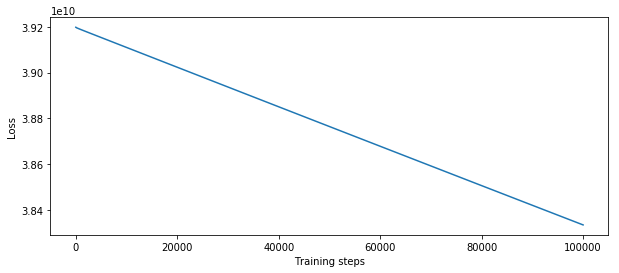

In [87]:
losses = []
training_steps = 100000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for i in range(training_steps):
        sess.run(update_weights, feed_dict = {input: X})

        loss_ = loss.eval(feed_dict = {input: X})
        losses.append(loss_)

    def predict(coords):
        return yhat.eval(feed_dict = {input: coords})
#         return np.argmax(yhat.eval(feed_dict = {input: coords}), axis=1)
    
#     prediction_areas = [
#         [-37.81053, 144.88467], # 1480000
#         [-37.82286, 144.87856],  #  705000
#         [-0.15239745,  0.21860468] #1035000.0]
#     ]
    prediction_areas = normalise_all_columns(
        make_two_dimensional_ndarray(
            [-37.81053, -37.82286],
            [144.87856, 144.87856]
            # [1480000, 705000]
        ))
    print(predict(prediction_areas))
fig, (ax2) = plt.subplots(1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

ax2.plot(range(0, training_steps), losses)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Training steps")

plt.show()